In [92]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib as imp
import datacleaner
import datetime
imp.reload(datacleaner)

from datacleaner import *

In [93]:
np.random.seed(1)
tf.keras.backend.clear_session()

bd = pd.read_csv(r"training_data.csv")

In [94]:
bd = pd.read_csv(r"training_data.csv")

def tratar_dados(bd):
    bd = ordernar(bd)
    bd = RoadsCleaner(bd)
    #bd = data(bd)
    bd = valores_em_falta(bd)
    bd = eliminar(bd)
    bd = incidentsNumbers(bd)
    bd = luminosidade(bd)
    bd = rainNumbers(bd)
    bd = delayNumbers(bd)
    bd = removeOutlier(bd)
    indice_treino, indice_val=split_data(bd, perc=10)
    escala, bd = data_normalization(bd, norm_range=(-1, 1))
    return bd,indice_treino,indice_val,escala

bd,indice_treino,indice_val,escala=tratar_dados(bd)

c:\Users\Lipe\Desktop\Universidade e coisas minhas\Programming\CSC\datacleaner.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd['magnitude_of_delay'][i] = None
c:\Users\Lipe\Desktop\Universidade e coisas minhas\Programming\CSC\datacleaner.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd["delay_in_seconds"][count] = valor


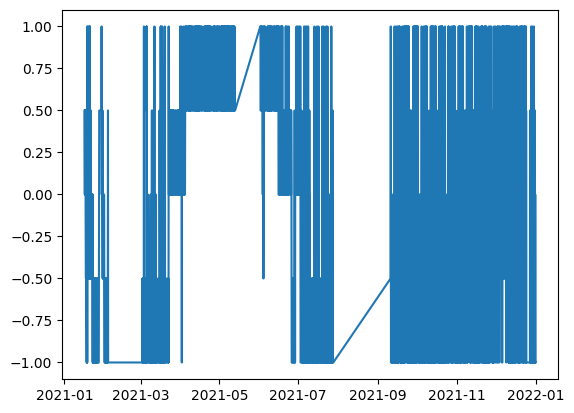

In [95]:
bd.index = pd.to_datetime(bd["record_date"], format="%Y-%m-%d %H:%M:00")
serie(bd,"incidents")
newBd = bd[["incidents","record_date"]]

<AxesSubplot:xlabel='record_date'>

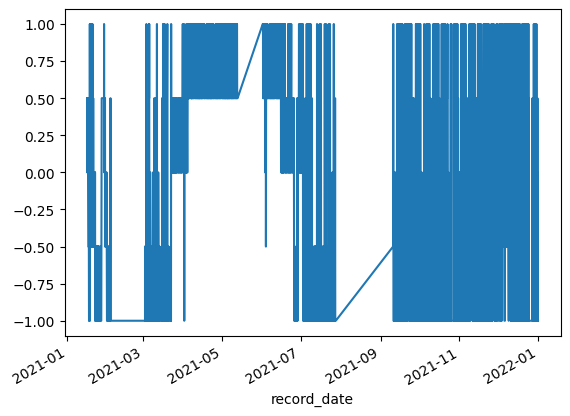

In [96]:
train, test = newBd[0:-600], newBd[-600:]
temp = bd["incidents"]
temp.plot()

In [97]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [98]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((4995, 5, 1), (4995,))

In [99]:
X_train1, y_train1 = X1[:4400], y1[:4400]
X_val1, y_val1 = X1[4400:4800], y1[4400:4800]
X_test1, y_test1 = X1[4800:], y1[4800:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((4400, 5, 1), (4400,), (400, 5, 1), (400,), (195, 5, 1), (195,))

Construção do modelo com uma LSTM

In [100]:
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [101]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [102]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
129/138 [===========================>..] - ETA: 0s - loss: 0.4558 - root_mean_squared_error: 0.6752

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


138/138 [==============================] - 5s 26ms/step - loss: 0.4508 - root_mean_squared_error: 0.6714 - val_loss: 0.5104 - val_root_mean_squared_error: 0.7144
Epoch 2/10
132/138 [===========================>..] - ETA: 0s - loss: 0.2895 - root_mean_squared_error: 0.5381

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


138/138 [==============================] - 3s 21ms/step - loss: 0.2872 - root_mean_squared_error: 0.5359 - val_loss: 0.4791 - val_root_mean_squared_error: 0.6922
Epoch 3/10
138/138 [==============================] - 0s 3ms/step - loss: 0.2413 - root_mean_squared_error: 0.4912 - val_loss: 0.4854 - val_root_mean_squared_error: 0.6967
Epoch 4/10
138/138 [==============================] - 0s 3ms/step - loss: 0.2350 - root_mean_squared_error: 0.4847 - val_loss: 0.4815 - val_root_mean_squared_error: 0.6939
Epoch 5/10
124/138 [=========================>....] - ETA: 0s - loss: 0.2332 - root_mean_squared_error: 0.4829

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


138/138 [==============================] - 3s 21ms/step - loss: 0.2302 - root_mean_squared_error: 0.4798 - val_loss: 0.4733 - val_root_mean_squared_error: 0.6879
Epoch 6/10
122/138 [=========================>....] - ETA: 0s - loss: 0.2276 - root_mean_squared_error: 0.4771

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


138/138 [==============================] - 3s 22ms/step - loss: 0.2251 - root_mean_squared_error: 0.4745 - val_loss: 0.4595 - val_root_mean_squared_error: 0.6779
Epoch 7/10
130/138 [===========================>..] - ETA: 0s - loss: 0.2199 - root_mean_squared_error: 0.4690

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


138/138 [==============================] - 3s 24ms/step - loss: 0.2196 - root_mean_squared_error: 0.4686 - val_loss: 0.4450 - val_root_mean_squared_error: 0.6671
Epoch 8/10
127/138 [==========================>...] - ETA: 0s - loss: 0.2181 - root_mean_squared_error: 0.4670

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


138/138 [==============================] - 3s 22ms/step - loss: 0.2150 - root_mean_squared_error: 0.4637 - val_loss: 0.4351 - val_root_mean_squared_error: 0.6596
Epoch 9/10
129/138 [===========================>..] - ETA: 0s - loss: 0.2093 - root_mean_squared_error: 0.4575

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


138/138 [==============================] - 3s 21ms/step - loss: 0.2108 - root_mean_squared_error: 0.4592 - val_loss: 0.4193 - val_root_mean_squared_error: 0.6475
Epoch 10/10
119/138 [========================>.....] - ETA: 0s - loss: 0.2089 - root_mean_squared_error: 0.4571

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


138/138 [==============================] - 3s 22ms/step - loss: 0.2061 - root_mean_squared_error: 0.4540 - val_loss: 0.4062 - val_root_mean_squared_error: 0.6373


In [103]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [104]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

138/138 [==============================] - 0s 1ms/step


,Train Predictions,Actuals
0,0.172829,0.0
1,0.064818,0.0
2,0.030273,0.0
3,0.005428,0.5
4,0.172829,0.0
...,...,...
4395,-0.879975,-1.0
4396,-0.879975,-1.0
4397,-0.879975,-1.0
4398,-0.879975,-1.0


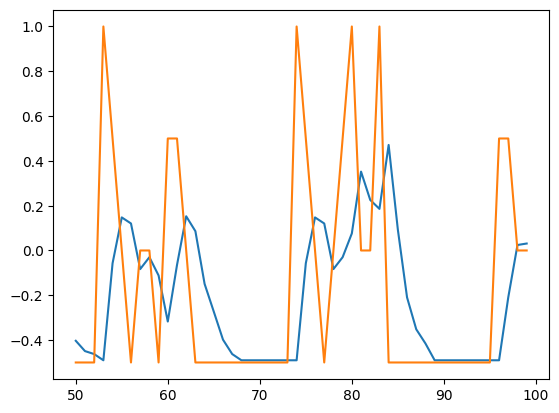

In [105]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [106]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

13/13 [==============================] - 0s 1ms/step


,Val Predictions,Actuals
0,-0.879975,-1.0
1,-0.879975,-1.0
2,-0.879975,-1.0
3,-0.879975,-1.0
4,-0.879975,-1.0
...,...,...
395,-0.845767,-1.0
396,-0.879975,-1.0
397,-0.879975,-1.0
398,-0.879975,-1.0


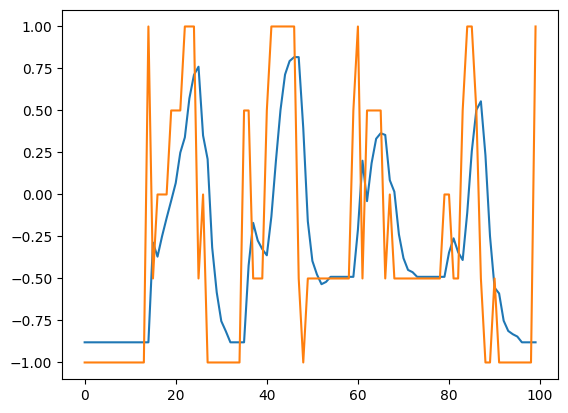

In [107]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [108]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

7/7 [==============================] - 0s 1ms/step


,Test Predictions,Actuals
0,-0.879975,-1.0
1,-0.879975,0.5
2,-0.423436,-0.5
3,-0.452545,-0.5
4,-0.444356,-0.5
...,...,...
190,-0.597709,0.0
191,-0.391734,-1.0
192,-0.601310,-1.0
193,-0.747296,-1.0


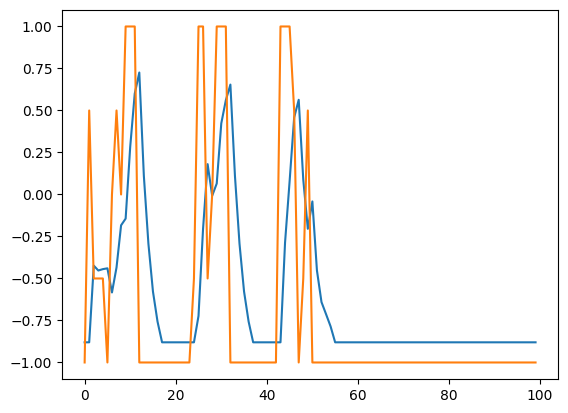

In [113]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

In [110]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

7/7 [==============================] - 0s 1ms/step


(     Predictions  Actuals
 0      -0.879975     -1.0
 1      -0.879975      0.5
 2      -0.423436     -0.5
 3      -0.452545     -0.5
 4      -0.444356     -0.5
 ..           ...      ...
 190    -0.597709      0.0
 191    -0.391734     -1.0
 192    -0.601310     -1.0
 193    -0.747296     -1.0
 194    -0.786108     -1.0
 
 [195 rows x 2 columns],
 0.31764132203050477)

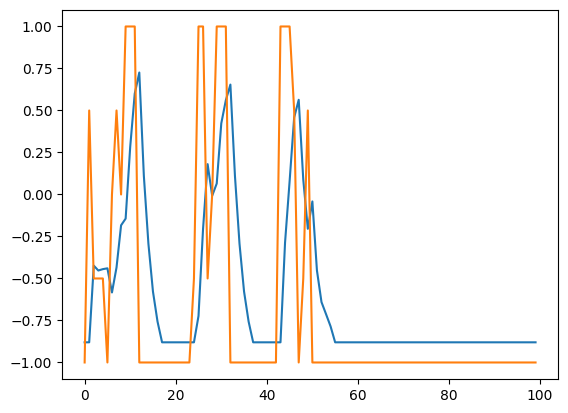

In [111]:
plot_predictions1(model1, X_test1, y_test1)